<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Exercise 6: Clustering</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Jan Leonard Schelhaasø</h3>
</div>

This notebook was adapted from:
* A course on geographic data science: https://darribas.org/gds_course/content/bG/diy_G.html

In [1]:
# import packages

import geopandas as gpd
import pandas as pd
import numpy as np

from sklearn import cluster
from pysal.lib import weights
from pysal.lib import examples

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Task I: NYC Geodemographics

We are going to try to get at the (geographic) essence of New York City. For that, we will rely on a data set of the census tracts for New York City we used for exercise 4 (from the [PySAL examples](https://pysal.org/libpysal/tutorial.html?highlight=examples#example-datasets)). Once you have the `nyc` object loaded, create a geodemographic classification using the following variables:

- `european`: Population White
- `asian`: Population Asian American
- `american`: Population American Indian
- `african`: Population African American
- `hispanic`: Population Hispanic
- `mixed`: Population Mixed race
- `pacific`: Population Pacific Islander
- `otherethni`: Population of other ethnicity

Before performing the clustering, make sure to standardize these variables (by using percentages instead of absolute numbers). NB: Compute the total population for each tract yourself (do *not* use the "poptot" column from the data set as this will lead to discrepancies.) The resulting values should range from 0 (no population of a given ethnic group in that tract) to 1 (all population of that tract is in the given ethnic group). Once this is ready, get to work with the following tasks:

1. Pick a number of clusters, N
1. Run K-Means for N clusters
1. Plot the different clusters on a map
1. Analyse the results, using for example bar plots, the KDE-plots from the lectures, etc.:
    - *What do you find?*
    - *What are the main characteristics of each cluster?*
    - *How are clusters distributed geographically?*
    - *Can you identify some groups concentrated on particular areas (e.g. China Town, Little Italy)?*
1. Redo with a different N; how do results depend on the number of chosen clusters?

In [2]:
examples.explain("NYC Socio-Demographics")

not available


Example not available: NYC Socio-Demographics
Example not downloaded: Chicago parcels
Example not downloaded: Chile Migration
Example not downloaded: Spirals


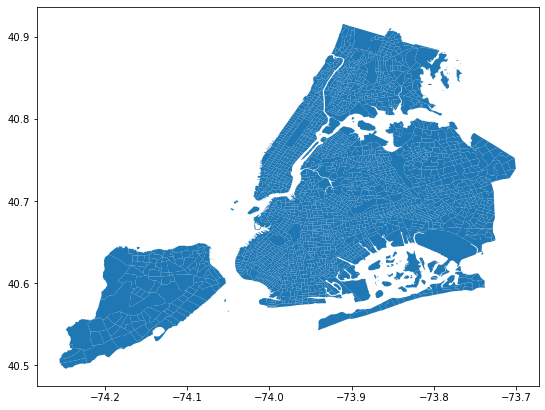

In [3]:
# Load data
nyc_data = examples.load_example("NYC Socio-Demographics")

nyc = gpd.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))

nyc.plot(figsize=(9, 9));

In [4]:
# Keep only needed columns
nyc = nyc[['european','asian','african','american','hispanic','mixed','pacific','otherethni','geometry']].copy()

# Compute new total column
nyc["total_population"] = nyc.apply(lambda x: sum([x.european, x.asian, x.african, x.american, x.hispanic, x.mixed, x.pacific, x.otherethni]), axis = 1)

# Standardize data
origins_cols = ['european','asian','african','american','hispanic','mixed','pacific','otherethni']

for colname, values in nyc[origins_cols].items():
    
    standardized_data = values / nyc['total_population']
    
    nyc[colname + '_stand'] = standardized_data 
    
# exclude non-populated boroughs from analysis
nyc.dropna(inplace=True)

In [5]:
# Pick number of clusters and run K-means

origins_stand = [x + '_stand' for x in origins_cols]

kmeans7 = cluster.KMeans(n_clusters=7, random_state=12345)

k7cls = kmeans7.fit(nyc[origins_stand])

In [6]:
# Save results to dataframe

nyc['k7cls'] = k7cls.labels_

# get array of cluster sizes
k7sizes = nyc.groupby('k7cls').size()

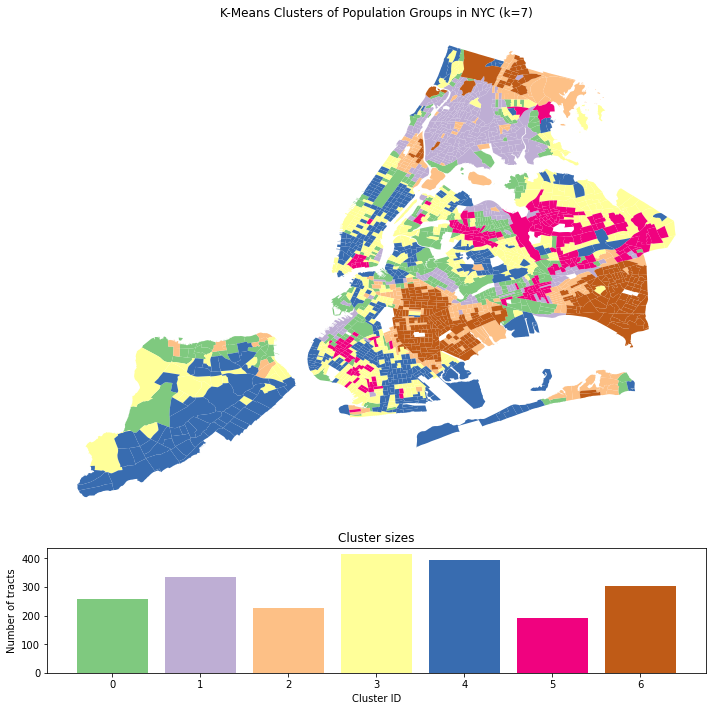

In [7]:
# define color mapping
mycols = {0: "#7fc97f", 
          1: "#beaed4", 
          2: "#fdc086", 
          3: "#ffff99", 
          4: "#386cb0",
          5: "#f0027f",
          6: "#bf5b17"}


fig, axs = plt.subplots(2,1, figsize=(10,10), gridspec_kw={'height_ratios': [4, 1]})

for c in range(len(mycols)):
    nyc[nyc["k7cls"]==c].plot(ax=axs[0], color = mycols[c])    
    
axs[0].set_title('K-Means Clusters of Population Groups in NYC (k=7)')
axs[0].set_axis_off()

axs[1].bar(k7sizes.index, k7sizes, color = mycols.values())
axs[1].set_xlabel("Cluster ID")
axs[1].set_ylabel("Number of tracts")
axs[1].set_title("Cluster sizes")

plt.tight_layout()

In [8]:
# Calculate the mean by group
k7means = nyc.groupby('k7cls')[origins_stand].mean() # We could also use the non-standardized cols here

# Show the table
k7means

european_stand  asian_stand  african_stand  american_stand  \
k7cls                                                               
0            0.346882     0.088443       0.091209        0.004095   
1            0.127296     0.035143       0.167038        0.003646   
2            0.145570     0.039771       0.480831        0.003400   
3            0.578261     0.165035       0.044287        0.002635   
4            0.811788     0.058292       0.019889        0.001805   
5            0.240744     0.443989       0.054588        0.005539   
6            0.051905     0.019288       0.802727        0.002068   

       hispanic_stand  mixed_stand  pacific_stand  otherethni_stand  
k7cls                                                                
0            0.319363     0.023779       0.000495          0.125734  
1            0.387386     0.025147       0.000215          0.254130  
2            0.197271     0.027816       0.000446          0.104895  
3            0.140401     0.021307       0.000574          0.047500  
4            0.075920     0.014584       0.000109          0.017613  
5            0.152259     0.026038       0.000381          0.076460  
6            0.074215     0.016038       0.000662          0.033097

In [9]:
# pass table from "wide" to "long":

# add id column
k7means_melt = k7means.copy()
k7means_melt["id"] = k7means.index

# "melt" by listing all ethnicity percentages in one "value" column
k7means_melt = pd.melt(k7means_melt, id_vars = "id", value_vars = k7means.columns[:-1]) 

# show resulting "long" table
k7means_melt.head(20)

id        variable     value
0    0  european_stand  0.346882
1    1  european_stand  0.127296
2    2  european_stand  0.145570
3    3  european_stand  0.578261
4    4  european_stand  0.811788
5    5  european_stand  0.240744
6    6  european_stand  0.051905
7    0     asian_stand  0.088443
8    1     asian_stand  0.035143
9    2     asian_stand  0.039771
10   3     asian_stand  0.165035
11   4     asian_stand  0.058292
12   5     asian_stand  0.443989
13   6     asian_stand  0.019288
14   0   african_stand  0.091209
15   1   african_stand  0.167038
16   2   african_stand  0.480831
17   3   african_stand  0.044287
18   4   african_stand  0.019889
19   5   african_stand  0.054588

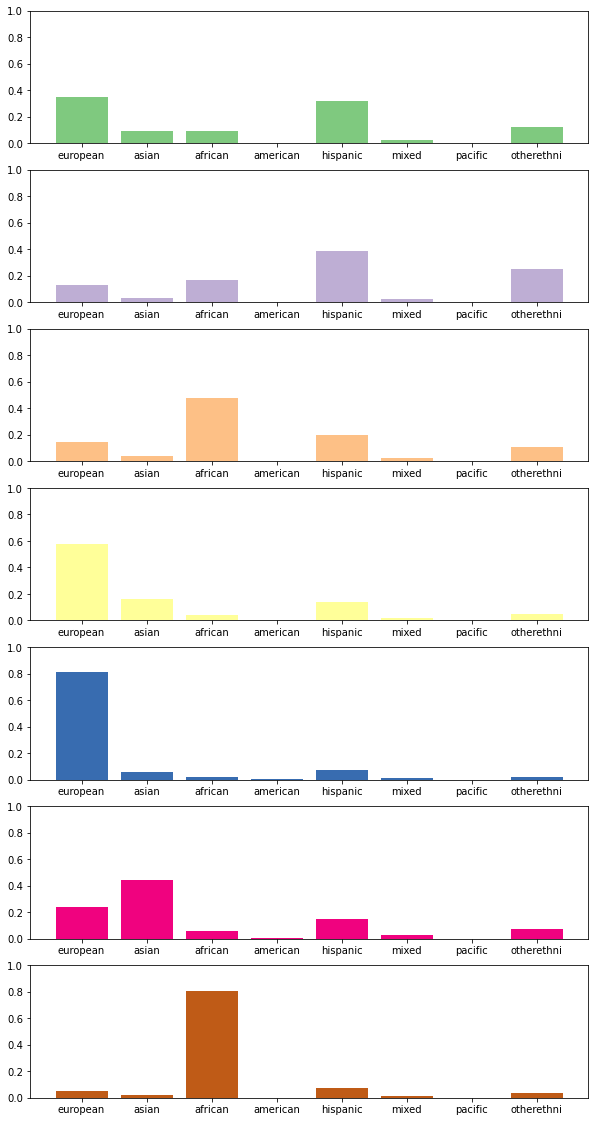

In [10]:
# seven subplots - one for each cluster - with height of bar determined by...stand
fig, axs = plt.subplots(7,1, figsize = (10,20))

# get labels (ethnicities from k7means)
xlabs = [colname.replace("_stand", "") for colname in k7means.columns]

for i in range(len((k7means))):
    axs[i].bar(x = xlabs, height = k7means.loc[i], color = mycols[i])
    axs[i].set_ylim([0,1])

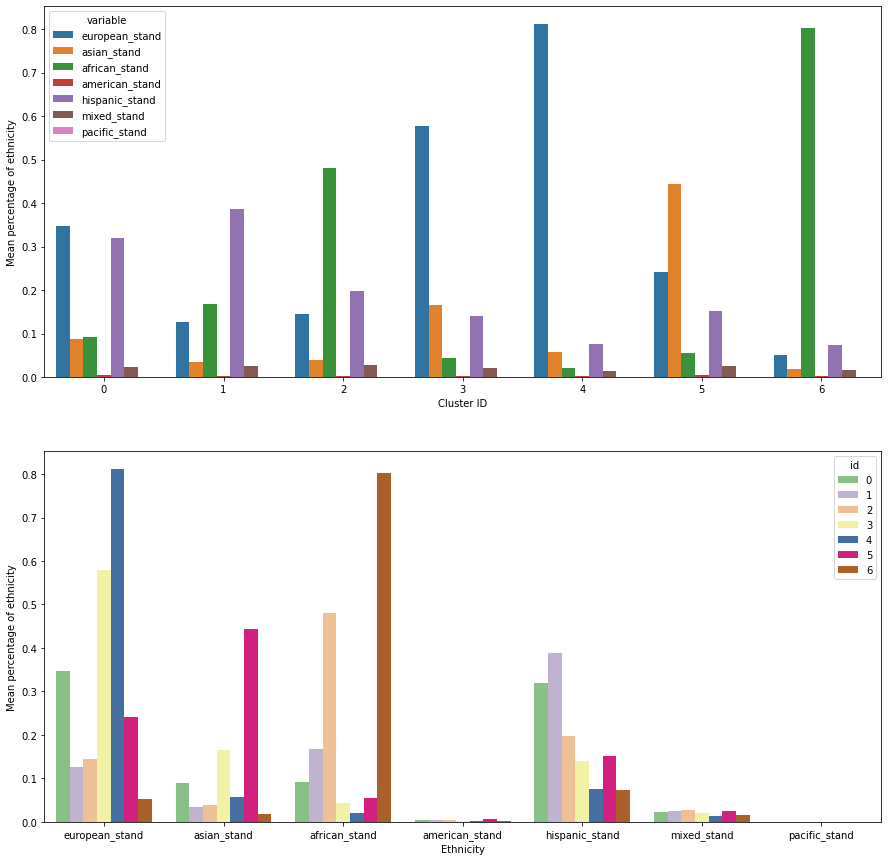

In [11]:
## Create bar plots of data in k7means with seaborn.barplot

# Start figure
fig, axs = plt.subplots(2,1, figsize = (15,15))

# Comparing clusters by ethnicity distribution:
sns.barplot(ax = axs[0], x="id", hue="variable", y="value", data=k7means_melt);
axs[0].set_xlabel("Cluster ID")
axs[0].set_ylabel("Mean percentage of ethnicity");

# Comparing ethnicity by cluster distribution:
sns.barplot(ax = axs[1], x="variable", hue="id", y="value", data=k7means_melt, palette = mycols);
axs[1].set_xlabel("Ethnicity")
axs[1].set_ylabel("Mean percentage of ethnicity");

### Interpretation
By cluster (region): 
- Regions 2 and 6 are majority Black neighbourhoods. They are also adjacent in several places.
- Regions 3 and 4 are majority white neighbourhoods. These regions are also adjacent in several places.
- Region 5 is mostly Asian.
- Region 0 and 1 are mostly Hispanic.
- ...

By ethnicity:
- Pacific and American-Indian are much lower in numbers
- Mixed race inhabitants seem to be more equally distributed amongst clusters
- Percentages of Asian and African American inhabitants seem to vary strongly amongst clusters, while percentages of white and hispanic inhabitants vary less
- ... 

## Task II: Regionalisation of Dar Es Salaam

For this task we will travel to Tanzania's Dar Es Salaam. We are using a dataset assembled to describe the built environment of the city centre. Let's load up the dataset first.

**Make sure you are connected to the internet when you run this cell.**


In [12]:
# Read the file 
db = gpd.read_file("http://darribas.org/gds_course/content/data/dar_es_salaam.geojson")

In [13]:
db.head()

index               id  street_length  street_linearity  \
0  897b4c16087ffff  897b4c8ce17ffff       0.011097          0.926700   
1  897b4c16097ffff  897b4c8ec67ffff       0.009181          0.983710   
2  897b4c160b3ffff  897b4c8eba3ffff       0.008357          0.962158   
3  897b4c160b7ffff  897b4c8dd97ffff       0.021292          0.884537   
4  897b4c16183ffff  897b4c8ce77ffff       0.008777          0.959906   

   building_density  building_coverage  \
0             138.0          15.789853   
1              33.0           3.722600   
2              82.0           9.491595   
3             122.0           7.245560   
4             113.0          11.806652   

                                            geometry  
0  POLYGON ((39.23750 -6.73264, 39.23752 -6.73071...  
1  POLYGON ((39.23914 -6.73559, 39.23916 -6.73366...  
2  POLYGON ((39.23416 -6.73254, 39.23418 -6.73061...  
3  POLYGON ((39.23082 -6.73244, 39.23084 -6.73050...  
4  POLYGON ((39.21745 -6.73202, 39.21747 -6.73009...

Geographically, this is what we are looking at:

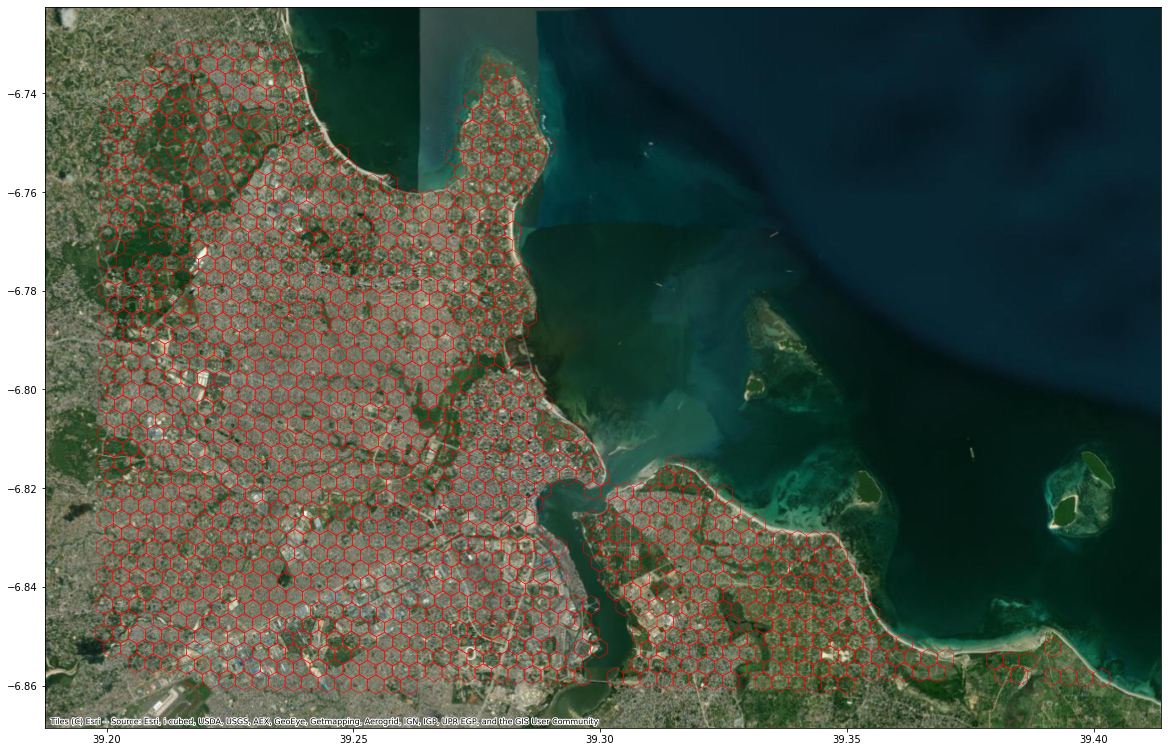

In [14]:
ax = db.plot(
    facecolor="none", 
    edgecolor="red",
    linewidth=0.5,
    figsize=(20, 20)
)
cx.add_basemap(
    ax, 
    crs=db.crs, 
    source=cx.providers.Esri.WorldImagery
)


We can inspect the table:

In [15]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   index              1291 non-null   object  
 1   id                 1291 non-null   object  
 2   street_length      1291 non-null   float64 
 3   street_linearity   1291 non-null   float64 
 4   building_density   1291 non-null   float64 
 5   building_coverage  1291 non-null   float64 
 6   geometry           1291 non-null   geometry
dtypes: float64(4), geometry(1), object(2)
memory usage: 70.7+ KB


Two main aspects of the built environment are considered: **the street network** and **buildings**. To capture those, the following variables have been calculated at for the H3 hexagonal grid system (more on this in a later lecture!), zoom level 8:

- Building density: number of buildings per hexagon
- Building coverage: proportion of the hexagon covered by buildings
- Street length: total length of streets within the hexagon
- Street linearity: a measure of how regular the street network is

With these at hand, your task is the following:

- **Develop a regionalisation that partitions Dar Es Salaam based on its built environment**

*These are only guidelines, feel free to improvise and go beyond what's set. The sky is the limit!*

For that, you can follow these suggestions:

- Create a spatial weights matrix to capture spatial relationships between hexagons.
    - If you use nearest neighbours: think about whether the geometry of the polygons should be accounted for;
    - If you use a distance band: think about an appropriate threshold and appropriate units (possibly change the CRS for that; hint: [this map of UTM zones](https://www.arcgis.com/home/item.html?id=b294795270aa4fb3bd25286bf09edc51) and a search on the https://epsg.io/ website can help!) 
- Set up a regionalisation algorithm with a given number of clusters (e.g. seven)
- Generate a geometry that contains only the boundaries of each region and visualise it (ideally with a satellite image as basemap for context); for an appropriate cmap browse [matplotlib's cmap palettes](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
- Rinse and repeat with several combinations of variables and number of clusters
- Pick your best. *Why have you selected it? What does it show? What are the main groups of areas based on the built environment?*

In [16]:
# Cols to include in analysis
build_env = ['street_length','street_linearity','building_density','building_coverage']

# Normalize variables of built environment (so that numbers range from 0 to 1):
for x in build_env:
    db[x] = (db[x]-db[x].mean())/db[x].std()
    db[x] = (db[x]-db[x].min())/(db[x].max()-db[x].min())

In [17]:
# deciding on an appropriate distance band: 
print("Hexagon areas:")
print(db.to_crs("EPSG:32737").geometry.area.head()) # area in square meters
print("Hexagon side lengths:")
print(np.sqrt(db.to_crs("EPSG:32737").geometry.area*2/(3*np.sqrt(3))).head()) # side length of hexagon in meters ( A = 3*sqrt(3)*(s**2))/2)

Hexagon areas:
0    118371.801787
1    118372.215320
2    118375.300285
3    118378.798526
4    118392.788937
dtype: float64
Hexagon side lengths:
0    213.450996
1    213.451369
2    213.454150
3    213.457304
4    213.469918
dtype: float64


In [18]:
# Create spatial weights matrix - using method a distance band
w_dist = weights.DistanceBand.from_dataframe(db.to_crs("EPSG:32737"), geom_col = "geometry", threshold = 800, binary = False)

# Create regionalizations with 7 clusters, based on distance band
agg_d7 = cluster.AgglomerativeClustering(n_clusters=7, connectivity=w_dist.sparse)
agg_d7_cls = agg_d7.fit(db[build_env])
db['agg_d7_cls'] = agg_d7_cls.labels_

# Create regionalizations with 5 clusters
agg_d5 = cluster.AgglomerativeClustering(n_clusters=5, connectivity=w_dist.sparse)
agg_d5_cls = agg_d5.fit(db[build_env])
db['agg_d5_cls'] = agg_d5_cls.labels_

/opt/conda/lib/python3.9/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:279: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:279: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


In [19]:
# Create spatial weights matrix - using nearest neighbors (first and second "order" around hexagon)
w_knn = weights.KNN.from_dataframe(db, k=18)

# Create regionalizations with 7 clusters
agg_knn7 = cluster.AgglomerativeClustering(n_clusters=7, connectivity=w_knn.sparse)
agg_knn7_cls = agg_knn7.fit(db[build_env])
db['agg_knn7_cls'] = agg_knn7_cls.labels_

# Create regionalizations with 5 clusters
agg_knn5 = cluster.AgglomerativeClustering(n_clusters=5, connectivity=w_knn.sparse)
agg_knn5_cls = agg_knn5.fit(db[build_env])
db['agg_knn5_cls'] = agg_knn5_cls.labels_


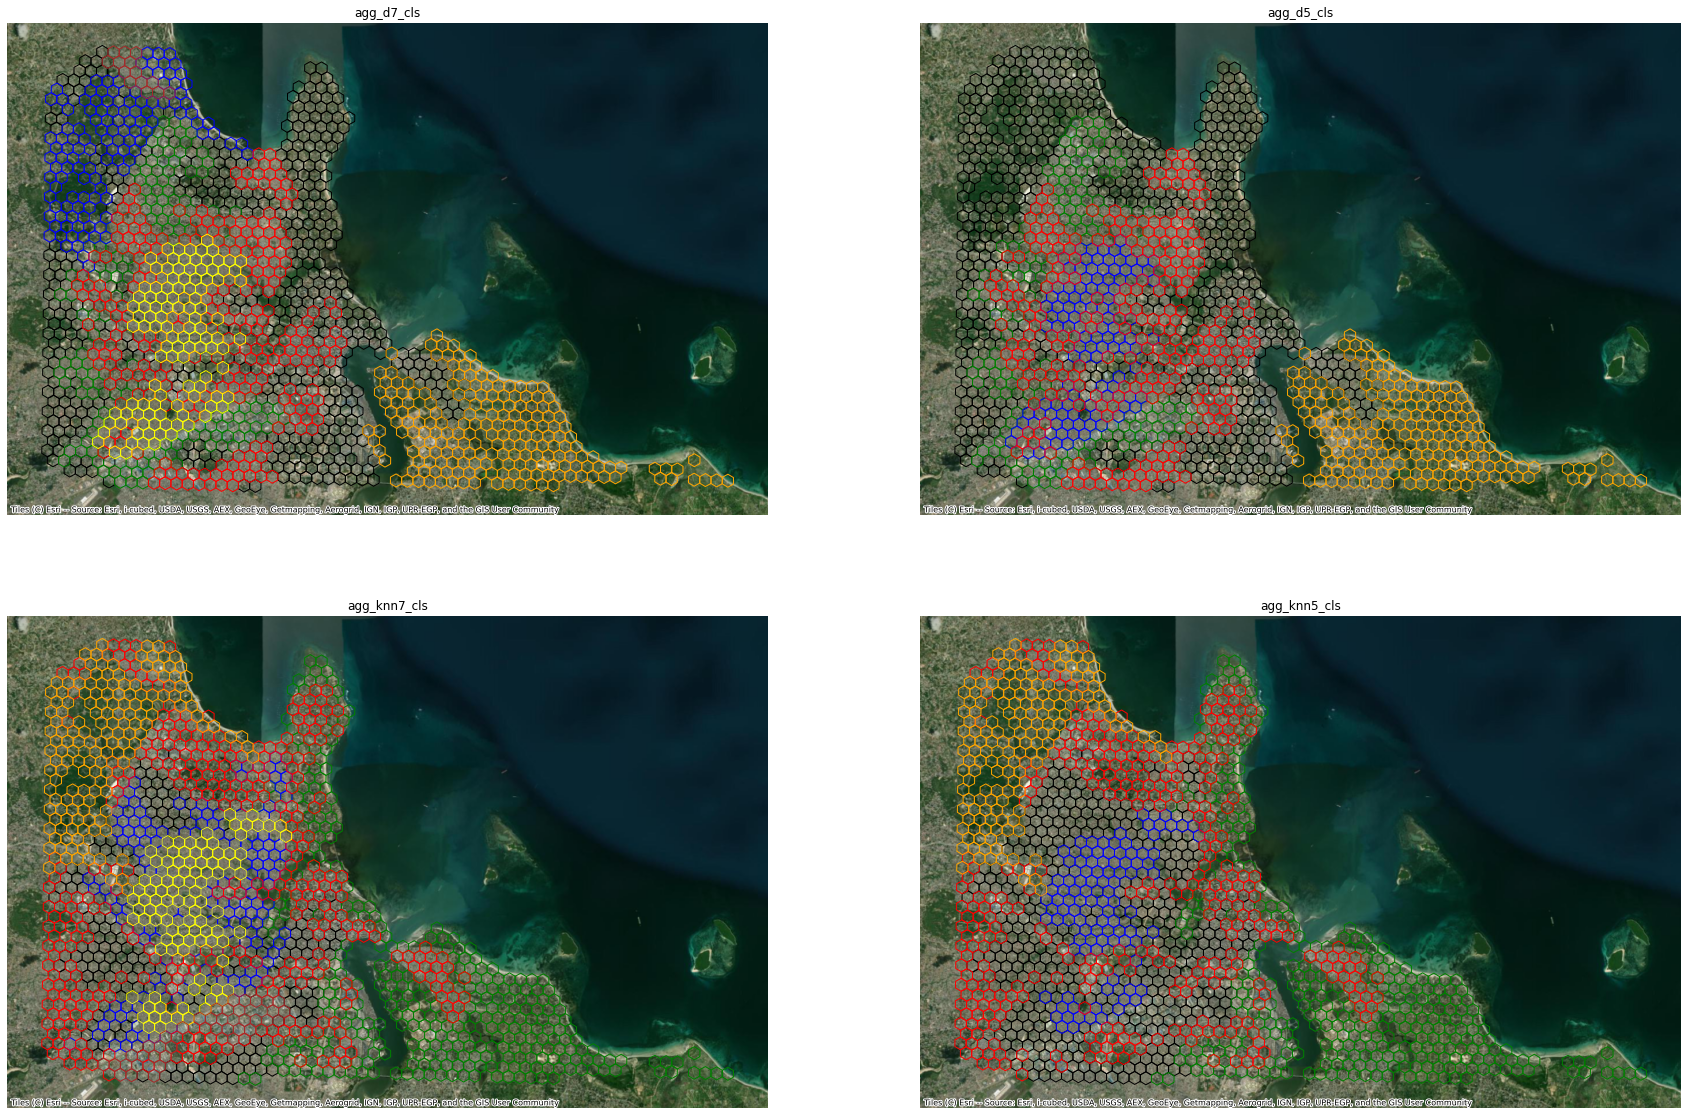

In [20]:
mycols = {0: "black", 
          1: "green", 
          2: "blue", 
          3: "red", 
          4: "orange",
          5: "yellow",
          6: "brown"}

cluster_cols = ['agg_d7_cls','agg_d5_cls','agg_knn7_cls','agg_knn5_cls']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))

axs = axs.flatten()

for i, col in enumerate(cluster_cols):
   
    ax = axs[i]

    for c in range(len(np.unique(db[col]))):
        db[db[col]==c].plot(ax=axs[i], edgecolor = mycols[c], facecolor = "none") 
    
    cx.add_basemap(
        axs[i], 
        crs=db.crs, 
        source=cx.providers.Esri.WorldImagery
    )


    ax.set_axis_off()
    
    ax.set_title(col)

#plt.tight_layout()
plt.show()

In [21]:
# plot distribution of built envir. values
mymethod = "agg_d7_cls"
db_melt = db[[mymethod]+build_env]
db_melt = db_melt.groupby(mymethod)[build_env].mean()
db_melt["id"] = db_melt.index
db_melt = pd.melt(db_melt, id_vars = "id", value_vars = build_env) 

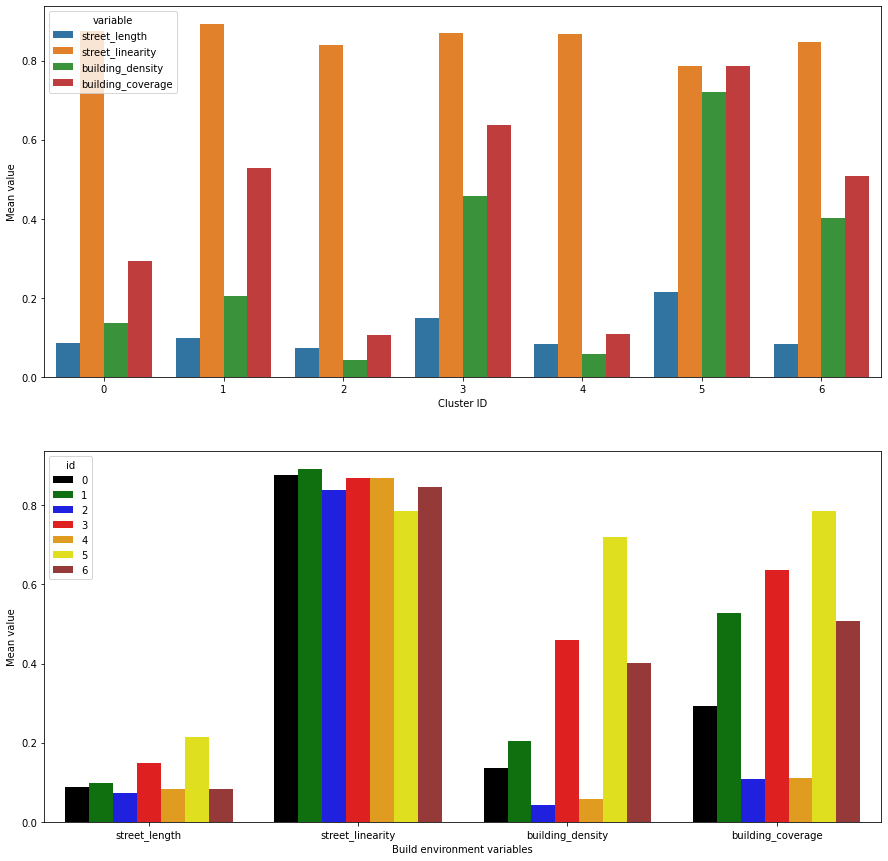

In [22]:
fig, axs = plt.subplots(2,1, figsize = (15,15))

# Comparing clusters by ethnicity distribution:
sns.barplot(ax = axs[0], x="id", hue="variable", y="value", data=db_melt);
axs[0].set_xlabel("Cluster ID")
axs[0].set_ylabel("Mean value");

# Comparing ethnicity by cluster distribution:
sns.barplot(ax = axs[1], x="variable", hue="id", y="value", data=db_melt, palette = mycols);
axs[1].set_xlabel("Build environment variables")
axs[1].set_ylabel("Mean value");

In [23]:
# Generate a geometry that contains only the boundaries of each region and visualise it (ideally with a satellite image as basemap for context);

# Example for 7 clusters based on distance band

d7_cls = db.dissolve(by='agg_d7_cls')

d7_cls.reset_index(inplace=True)

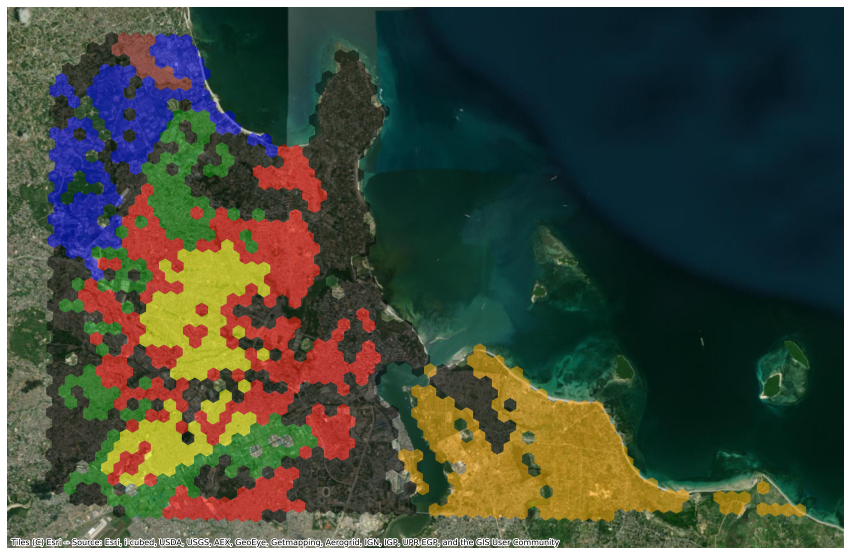

In [24]:
fig, ax = plt.subplots(figsize=(15,15))

for c in range(len(np.unique(d7_cls["agg_d7_cls"]))):
        d7_cls[d7_cls["agg_d7_cls"]==c].plot(ax=ax, facecolor = mycols[c], alpha = 0.5) 

cx.add_basemap(
        ax=ax, 
        crs=db.crs, 
        source=cx.providers.Esri.WorldImagery)
        
ax.set_axis_off()

### Interpretation
By cluster (region): 
- Cluster 5 (yellow) seems to contain the most densely built areas
- Clusters 2 and 4 (blue and orange) are much less densely built
- ...

By environment variable:
- Building density and coverage vary more strongly than street length and linearity
- The cluster with the highest builing coverage has the highest street length, but not the highest street linearity
- ...